<a href="https://colab.research.google.com/github/HarounH/smol/blob/main/rl/correlated_datums.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

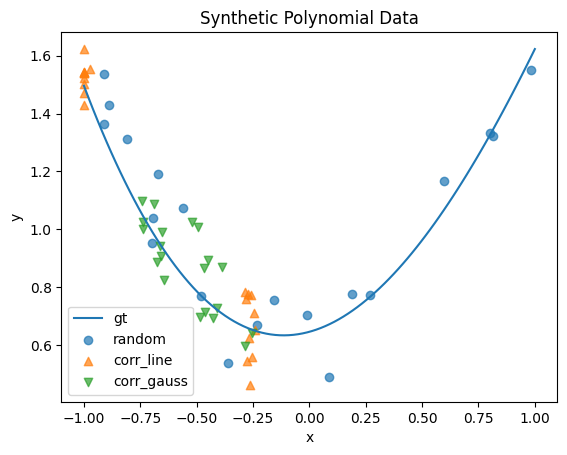

In [26]:
import itertools
from dataclasses import dataclass
from typing import Tuple, List, Optional

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)


@dataclass
class RandomPolynomialDataGenerator:
    """
    Generate synthetic data (X, y) from a randomly generated polynomial.

    - Input: 1 or 2 variables (configurable via input_dim).
    - Output: 1 variable (y).
    - Output is: y = P(x) + noise, where P is a random polynomial.
    """
    input_dim: int = 1          # 1 or 2
    degree: int = 3             # maximum total degree of the polynomial
    coeff_range: Tuple[float, float] = (-1.0, 1.0)
    x_range: Tuple[float, float] = (-1.0, 1.0)
    noise_std: float = 0.001
    random_state: Optional[int] = None

    def __post_init__(self):
        if self.input_dim not in (1, 2):
            raise ValueError("input_dim must be 1 or 2")

        self.rng = np.random.default_rng(self.random_state)
        self.monomials = self._generate_monomials(self.input_dim, self.degree)
        self.coeffs = self._sample_coeffs()

    @staticmethod
    def _generate_monomials(input_dim: int, degree: int) -> List[Tuple[int, ...]]:
        """
        Generate all exponent tuples (e1, ..., ed) such that:
            e1 + ... + ed <= degree and each ei >= 0.
        """
        exponents = []
        for total_deg in range(degree + 1):
            # All non-negative integer solutions to sum(e) == total_deg
            # using product and filtering.
            for exp in itertools.product(range(total_deg + 1), repeat=input_dim):
                if sum(exp) == total_deg:
                    exponents.append(exp)
        return exponents

    def _sample_coeffs(self) -> np.ndarray:
        low, high = self.coeff_range
        return self.rng.uniform(low, high, size=len(self.monomials))

    def resample_polynomial(self):
        """
        Resample the polynomial coefficients while keeping the same monomial structure.
        """
        self.coeffs = self._sample_coeffs()

    def _evaluate_polynomial(self, X: np.ndarray) -> np.ndarray:
        """
        Evaluate the random polynomial at points X.

        X: shape (n_samples, input_dim)
        Returns: y of shape (n_samples,)
        """
        X = np.atleast_2d(X)
        if X.shape[1] != self.input_dim:
            raise ValueError(f"Expected X with shape (n_samples, {self.input_dim}), got {X.shape}")

        y = np.zeros(X.shape[0], dtype=float)
        for coeff, exps in zip(self.coeffs, self.monomials):
            # Compute term = coeff * prod_j x_j ** exps[j]
            term = coeff * np.prod(X ** np.array(exps), axis=1)
            y += term
        return y

    def random_sample(self, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Sample X and y from the random polynomial with Gaussian noise.

        Returns:
            X: np.ndarray of shape (n_samples, input_dim)
            y: np.ndarray of shape (n_samples,)
        """
        x_low, x_high = self.x_range
        X = self.rng.uniform(x_low, x_high, size=(n_samples, self.input_dim))
        y_clean = self._evaluate_polynomial(X)
        noise = self.rng.normal(loc=0.0, scale=self.noise_std, size=n_samples)
        y = y_clean + noise
        return X, y

    def correlated_sample(self, n_samples, n_seeds, x_range_shrinkage: float = 0.1, linear: bool = False) -> Tuple[np.ndarray, np.ndarray]:
        x_low, x_high = self.x_range
        seeds_X = self.rng.uniform(x_low, x_high, size=(n_seeds, self.input_dim))
        num_samples_per_seed = n_samples // n_seeds
        maybe_samples_x = seeds_X.reshape(n_seeds, 1, self.input_dim)
        radius_around_seeds_X = ((x_high - x_low) * x_range_shrinkage) / 2
        samples_X = np.tile(seeds_X, (1, num_samples_per_seed, 1))
        if linear:
            frac = (
                np.arange(num_samples_per_seed) / (num_samples_per_seed - 1)
            ).reshape(1, num_samples_per_seed, 1).repeat(n_seeds, axis=1)
            seed_low = samples_X - radius_around_seeds_X
            seed_high = samples_X + radius_around_seeds_X
            X = seed_low + frac * seed_high

        else:
            # gaussian sample
            X = samples_X + radius_around_seeds_X * self.rng.normal(size=samples_X.shape)
        X = np.clip(X, x_low, x_high)
        X = X.reshape(-1, self.input_dim)
        y_clean = self._evaluate_polynomial(X)
        noise = self.rng.normal(loc=0.0, scale=self.noise_std, size=n_samples)
        y = y_clean + noise
        return X, y

    def get_X(self, num_points, verbose: bool = False):
        if self.input_dim == 1:
            X = np.arange(num_points) / (num_points - 1)
            low, high = self.x_range
            range = high - low
            X = low + range * X
            X = X.reshape(-1, self.input_dim)

            return X
        else:
            return None

    def draw_line(self, ax, num_points, verbose: bool = False):
        X = self.get_X(num_points)
        if self.input_dim == 1:
            y_clean = self._evaluate_polynomial(X)
            ax.plot(X, y_clean, label="gt")
        elif verbose:
            print(f"line for {self.input_dim} not supported")

def plot_polynomial_data(X: np.ndarray, y: np.ndarray, label: str = "", marker: str = "o", title: str = "Synthetic Polynomial Data", ax=None):
    """
    Plot synthetic polynomial data.

    - If X has shape (n_samples,) or (n_samples, 1): 2D scatter (x vs y).
    - If X has shape (n_samples, 2): 3D scatter (x1, x2 vs y).

    Args:
        X: np.ndarray, shape (n_samples,) or (n_samples, 1 or 2)
        y: np.ndarray, shape (n_samples,)
        title: plot title
    """
    X = np.asarray(X)
    y = np.asarray(y)

    if X.ndim == 1:
        X = X.reshape(-1, 1)

    if X.shape[0] != y.shape[0]:
        raise ValueError("X and y must have the same number of samples")

    if X.shape[1] == 1:
        # 2D scatter plot
        if ax is None:
            fig, ax = plt.subplots()
        ax.scatter(X[:, 0], y, alpha=0.7, label=label, marker=marker)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(title)
        # plt.show()

    elif X.shape[1] == 2:
        # 3D scatter plot
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
        ax.scatter(X[:, 0], X[:, 1], y, alpha=0.7, label=label, marker=marker)
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("y")
        ax.set_title(title)
        # plt.show()

    else:
        raise ValueError("plot_polynomial_data only supports 1D or 2D inputs (input_dim 1 or 2).")


generator = RandomPolynomialDataGenerator(noise_std=0.1)
n_samples = 20
n_seeds = 2
x_random, y_random = generator.random_sample(n_samples)
x_corr_line, y_corr_line = generator.correlated_sample(n_samples, n_seeds, linear=True)
x_corr_gauss, y_corr_gauss = generator.correlated_sample(n_samples, n_seeds, linear=False)

fig, ax = plt.subplots()
generator.draw_line(ax)
plot_polynomial_data(x_random, y_random, label="random", ax=ax, marker="o")
plot_polynomial_data(x_corr_line, y_corr_line, label="corr_line", ax=ax, marker="^")
plot_polynomial_data(x_corr_gauss, y_corr_gauss, label="corr_gauss", ax=ax, marker="v")
plt.legend(loc="best")
plt.show()

In [15]:
num_samples_per_seed = 3
n_seeds = 3
np.tile(
    (
        np.arange(num_samples_per_seed) / (num_samples_per_seed - 1)
    ).reshape(1, num_samples_per_seed, 1),
    (1, n_seeds, 1),
)


array([[[0. ],
        [0.5],
        [1. ],
        [0. ],
        [0.5],
        [1. ],
        [0. ],
        [0.5],
        [1. ]]])